# Cointegration Experiment
This is a proof of concept for selecting pairs of stocks that are cointegrated. Note that this requires an API key, so follow the instructions in the README to get one.
**This notebook relies on the scripts in the src folder.**

In [15]:
from datetime import datetime, timedelta
from datetime import time
from itertools import combinations
import os
import sys

from alpaca.data.historical import StockHistoricalDataClient
from alpaca.data.requests import StockBarsRequest
from alpaca.data.timeframe import TimeFrame
from dotenv import load_dotenv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from tqdm import tqdm

from src.utilities import getenv, load_dataframe, save_dataframe
from src.utilities.plotting import (
    plot_price_data,
    plot_split_dataframe,
    plt_show,
)
from src.utilities.bars import download_close_prices, BarUtils
# add the src directory to the path
sys.path.append(os.path.join("..", "src"))

load_dotenv()

ALPACA_API_KEY = getenv("ALPACA_API_KEY")
ALPACA_API_SECRET = getenv("ALPACA_API_SECRET")
DATA_DIR = getenv("DATA_DIR")

Define the tickers and timeframes.

In [16]:
utility_tickers = [
    "NEE", "EXC", "D", "PCG", "XEL", 
    "ED", "WEC", "DTE", "PPL", "AEE", 
    "CNP", "FE", "CMS", "EIX", "ETR", 
    "EVRG", "LNT", "PNW", "IDA", "AEP", 
    "DUK", "SRE", "ATO", "NRG",
]
refresh_bars = False # set to true to refresh the bars. this requires the alpaca api key and secret to be set in the .env file
start_date = datetime(2023, 1, 1)
end_date = datetime.today() - timedelta(minutes=15)
timeframe = TimeFrame.Hour

Load the data.

Loading data/NEE_EXC_D_PCG_XEL_ED_WEC_DTE_PPL_AEE_CNP_FE_CMS_EIX_ETR_EVRG_LNT_PNW_IDA_AEP_DUK_SRE_ATO_NRG_2023-01-01_2025-07-18_1Hour_close_prices.pkl


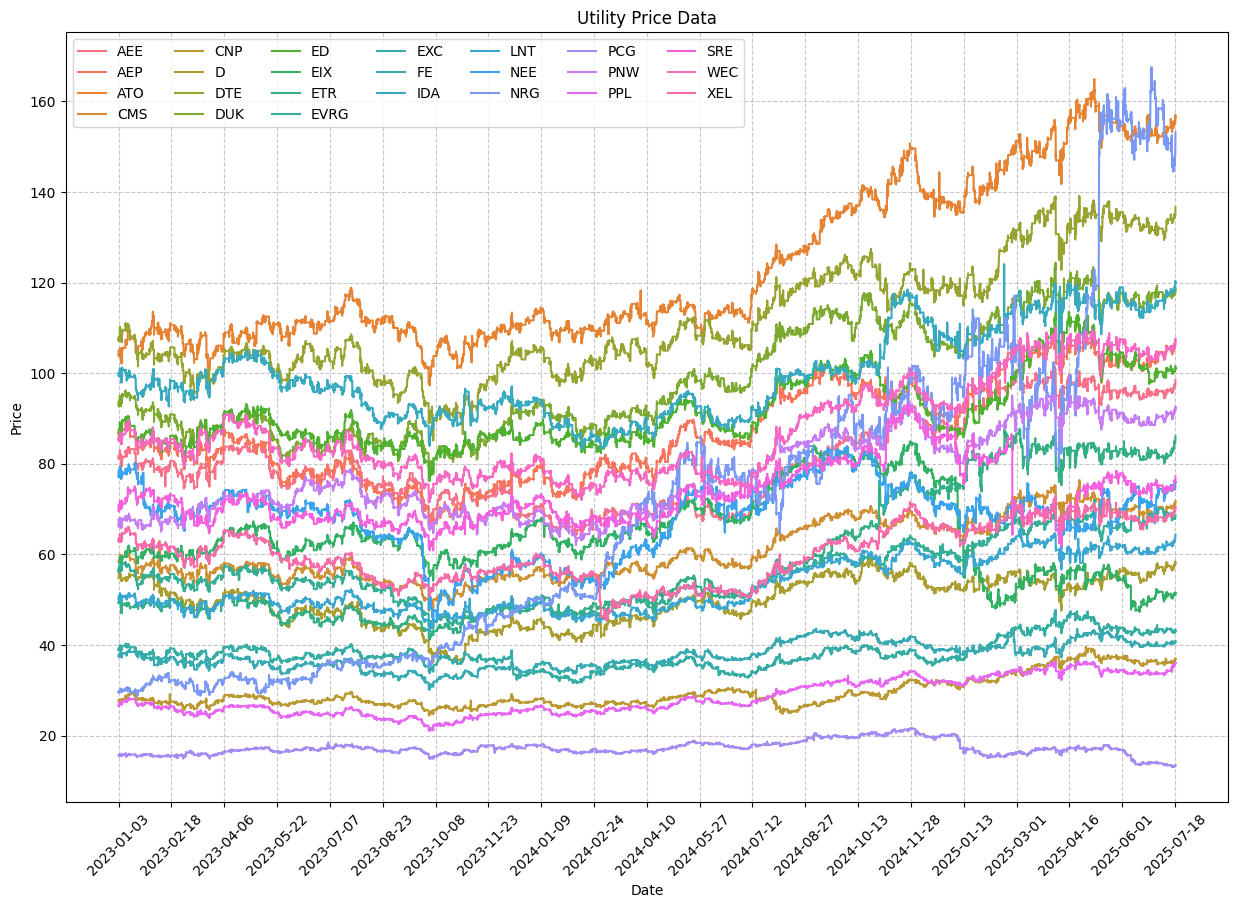

In [ ]:
close_prices = download_close_prices(utility_tickers, start_date, end_date, timeframe, refresh_bars, DATA_DIR)

plot_price_data(close_prices, "Utility Price Data")
plt_show(prefix="utility_price_data")


## Analyze the relationship between prices
For selection, we take the spread (price difference) over all combinations of two tickers. In order for a pairs trading strategy to work, the prices in a pair must be cointegrated. We use the Johansen test for that.

In [18]:
tt_split = 0.9

# we want the strategy to train on
train_prices = close_prices.iloc[:int(tt_split * len(close_prices))]
test_prices = close_prices.iloc[int(tt_split * len(close_prices)):]
print(f"Train prices: {train_prices.shape}")
print(f"Test prices: {test_prices.shape}")

Train prices: (20025, 24)
Test prices: (2225, 24)


Engle Granger test

In [19]:
cointegration_results = pd.DataFrame(columns=["p-value", "alpha", "beta", "test_stat"])
for primary, secondary in tqdm(combinations(utility_tickers, 2)):
    # make identifie, alphabetically sorted
    pair = tuple(sorted([primary, secondary]))
    if pair in cointegration_results:
        continue

    # model with linear regression
    results = sm.OLS(train_prices[primary],
                   sm.add_constant(train_prices[secondary])).fit()
    alpha = results.params.iloc[0]
    beta = results.params.iloc[1]

    # calculate the residuals
    residuals = train_prices[primary] - beta * train_prices[secondary] - alpha
    # calculate the adf test statistic
    adf_stat = adfuller(residuals, maxlag=1)
    test_stat, p_value, lags_used, nobs, critical_values = adf_stat[:5]

    cointegration_results = pd.concat([cointegration_results, pd.DataFrame({"p-value": p_value, "alpha": alpha, "beta": beta, "test_stat": test_stat}, index=[pair])])

0it [00:00, ?it/s]/tmp/ipykernel_34369/3677686693.py:20: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  cointegration_results = pd.concat([cointegration_results, pd.DataFrame({"p-value": p_value, "alpha": alpha, "beta": beta, "test_stat": test_stat}, index=[pair])])
276it [00:01, 148.99it/s]


Sort pairs by results and take the lowest 10 values. 

In [20]:
# sort by p-value
cointegration_results = cointegration_results.sort_values(by="p-value")
cointegration_results


,p-value,alpha,beta,test_stat
"(CMS, DTE)",8.628924e-10,5.738696,1.727222,-6.971756
"(CMS, PPL)",3.204791e-08,-6.401833,0.569751,-6.312747
"(IDA, WEC)",2.313007e-07,-11.018484,0.985060,-5.936603
"(AEE, WEC)",2.910660e-07,9.884666,0.958298,-5.891935
"(EVRG, WEC)",3.532969e-07,5.839844,1.460683,-5.854111
...,...,...,...,...
"(ED, EIX)",9.028547e-01,71.959475,0.276659,-0.441955
"(DTE, EIX)",9.124045e-01,82.976150,0.394815,-0.386035
"(CMS, EIX)",9.279846e-01,43.402388,0.248606,-0.282223
"(CNP, SRE)",9.445994e-01,17.282600,0.155410,-0.146556


Pick the top pair and plot the residual adjusted by alpha and beta.

20025 2225


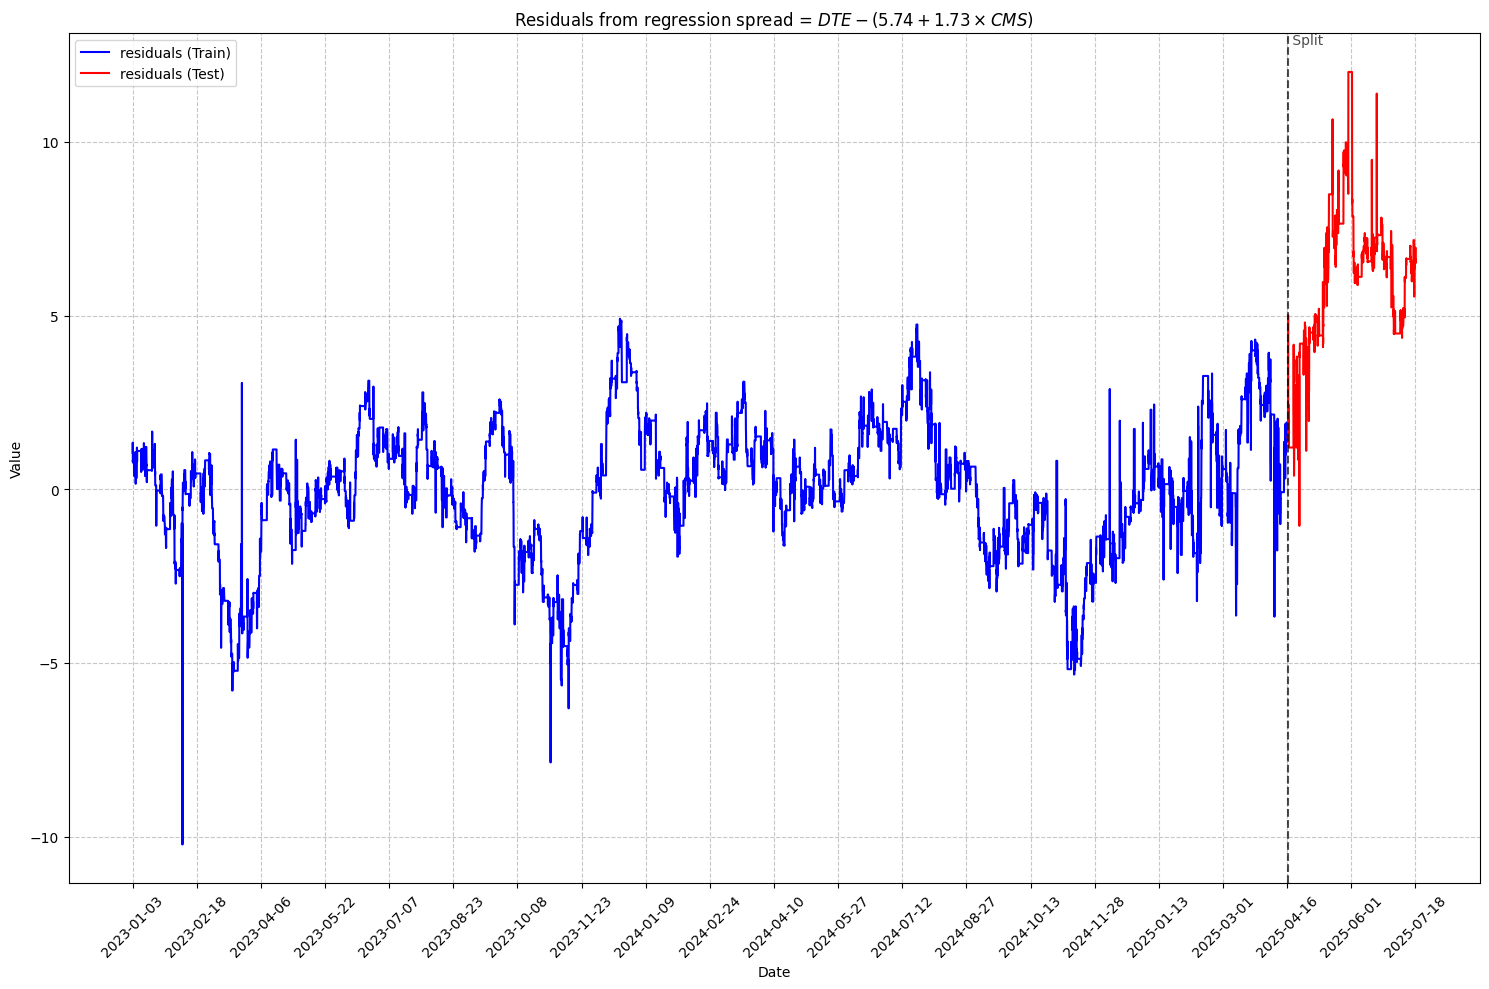

In [21]:
best = cointegration_results.iloc[0]
primary, secondary = best.name
alpha, beta = best["alpha"], best["beta"]
# calculate the residuals for train and test
residuals_train = train_prices[secondary] - (alpha + beta * train_prices[primary])
residuals_test = test_prices[secondary] - (alpha + beta * test_prices[primary])
print(len(residuals_train), len(residuals_test))
# combine the residuals into a single dataframe
combined_residuals = pd.DataFrame(pd.concat([residuals_train, residuals_test]), columns=["residuals"])

# plot the residuals
plot_split_dataframe(combined_residuals, len(train_prices), title=rf"Residuals from regression spread = ${secondary} - ({alpha:.2f} + {beta:.2f}\times {primary})$")
plt_show(prefix="residuals")

We use a rolling beta to determine spread pricing
https://github.com/quantrocket-codeload/quant-finance-lectures/blob/master/quant_finance_lectures/Lecture42-Introduction-to-Pairs-Trading.ipynb